In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('mainset.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514704 entries, 0 to 554645
Data columns (total 58 columns):
nba_game_date            514704 non-null object
nba_season_id            514704 non-null int64
br_location              514704 non-null object
nba_gm_type              514704 non-null object
br_outcome               514704 non-null object
home_plus_minus          514704 non-null int64
nba_game_id              514704 non-null int64
nba_team_id              514704 non-null int64
nba_team_abbreviation    514704 non-null object
nba_team_city            514704 non-null object
nba_player_id            514704 non-null int64
nba_player_name          514704 non-null object
nba_start_position       269063 non-null object
nba_comment              0 non-null float64
nba_seconds              514704 non-null int64
nba_fgm                  514704 non-null float64
nba_fga                  514704 non-null float64
nba_fg_pct               514704 non-null float64
nba_fg3m                 514704 

In [3]:
df['age'] = pd.to_datetime(df['nba_game_date']) - pd.to_datetime(df['birthdate'])

### Get feature descriptions

In [4]:
import requests
from bs4 import BeautifulSoup

### Collect data dictionary
- Sources basketball-reference

In [5]:
br_glossary_url = 'https://www.basketball-reference.com/about/glossary.html'

r = requests.get(br_glossary_url)
soup = BeautifulSoup(r.text, 'html.parser')
content = soup.find('div', attrs={'class' : 'section_content'})
br_glossary = {a.text.replace('\n','').split(' -   ')[0] : \
               a.text.replace('\n','').split(' -   ')[1][:-4] 
               for a in content.find_all('li')}
br_glossary

{'2P': '2-Point Field Goals',
 '2P%': '2-Point Field Goal Percentage; the formula is 2P / 2PA.',
 '2PA': '2-Point Field Goal Attempts',
 '3P': '3-Point Field Goals (available since the 1979-80 season in the NBA)',
 '3P%': '3-Point Field Goal Percentage (available since the 1979-80 season in the  NBA); the formula is 3P / 3PA.',
 '3PA': '3-Point Field Goal Attempts (available since the 1979-80 season in the  NBA)',
 'Age': 'Age; player age on February 1 of the given season.',
 'AST': 'Assists',
 'AST%': 'Assist Percentage (available since the 1964-65 season in the NBA); the  formula is 100 * AST / (((MP / (Tm MP / 5)) * Tm FG) - FG).  Assist percentage is an estimate of the percentage of teammate field goals  a player assisted while he was on the floor.',
 'Award Share': 'The formula is (award points) / (maximum number of award points).  For  example, in the 2002-03 MVP votingTim Duncan had 962 points out of a  possible 1190.  His MVP award share is 962 / 1190 = 0.81.',
 'BLK': 'Blocks 

In [6]:
bleacher_glossary_url = \
'https://bleacherreport.com/articles/1813902-advanced-nba-stats-for-dummies-how-to-understand-the-new-hoops-math'

r = requests.get(bleacher_glossary_url)
soup = BeautifulSoup(r.text, 'html.parser')
content = soup.find_all('article', attrs={'class' : 'page'})
bleacher_glossary = {a.h1.text : a.ol.text.strip() for a in \
                     content[0].find_all('div', attrs={'class' : 'organism'})}

### Some feature selection
- Pace - take effective
- Off rating - take effective
- Def rating - take effective
- Net rating - take effective
- All encompassing metrics
- shooting percentages

In [7]:
pace_metrics = [col for col in df.columns if 'pace' in col]
pace_metrics

['nba_e_pace', 'nba_pace', 'nba_pace_per40']

In [8]:
rating_metrics = [col for col in df.columns if 'rating' in col]
rating_metrics

['nba_e_off_rating',
 'nba_off_rating',
 'nba_e_def_rating',
 'nba_def_rating',
 'nba_e_net_rating',
 'nba_net_rating']

In [9]:
all_encompassing_metrics = ['br_game_score',
                            'nba_pie',
                            'nba_plus_minus']
all_encompassing_metrics

['br_game_score', 'nba_pie', 'nba_plus_minus']

In [10]:
shooting_stats = [col for col in df.columns if 'fg' in col] \
+ ['nba_ts_pct'] + [col for col in df.columns if 'ft' in col]
shooting_stats

['nba_fgm',
 'nba_fga',
 'nba_fg_pct',
 'nba_fg3m',
 'nba_fg3a',
 'nba_fg3_pct',
 'nba_efg_pct',
 'nba_ts_pct',
 'nba_ftm',
 'nba_fta',
 'nba_ft_pct']

In [11]:
import pickle

# pickle.dump(br_glossary, open("br_glossary.pickle", "wb"))
# pickle.dump(bleacher_glossary, open("bleacher_glossary.pickle", "wb"))

### Considerations

- pct shooting stats do not represent true shooting percentages:
    - Consider player X goes 0/1 in game a, &, 5/10 in game b if turned into a rolling average as is applied to other stats would result in .25 instead of .45
    - Solution: remove pct shooting statistics and apply after rolling windows, as fgm/fga
    - Alternative: fill 0 values with np.nan if no shots where taken in that game by player X
    
- Other pct and ratio stats:
    - Same issue as above
    - Solution: fill 0 values with np.nan if no counting stat for that metric is recorded for player X in that game

- make decision about efg
    - efg_pct :  (.5 X 3PM + FG) / FGA
    - ts_pct  :  PTS / ((.44 X FTA + FGA) X 2)
- remove pie

In [12]:
effective_variables = [col for col in df.columns if '_e_' in col]
effective_variables

['nba_e_off_rating', 'nba_e_def_rating', 'nba_e_net_rating', 'nba_e_pace']

In [13]:
shoot_remove = [col for col in shooting_stats if 'pct' in col]
shoot_remove

['nba_fg_pct', 'nba_fg3_pct', 'nba_efg_pct', 'nba_ts_pct', 'nba_ft_pct']

In [14]:
# Final column list before standardising

columns = [col for col in df.loc[:,:'nba_start_position']] + ['age', 'nba_height'] \
+ [col for col in df.loc[:,'nba_seconds':'nba_pts'] if col not in shoot_remove] \
+['nba_poss'] + effective_variables \
+ [col for col in df.loc[:,'nba_plus_minus':] if col not in shoot_remove \
and col not in rating_metrics and col not in pace_metrics and col not in \
   ['nba_pie','nba_height','birthdate','nba_plus_minus','age', 'nba_poss']] \
+ ['nba_plus_minus']
columns

['nba_game_date',
 'nba_season_id',
 'br_location',
 'nba_gm_type',
 'br_outcome',
 'home_plus_minus',
 'nba_game_id',
 'nba_team_id',
 'nba_team_abbreviation',
 'nba_team_city',
 'nba_player_id',
 'nba_player_name',
 'nba_start_position',
 'age',
 'nba_height',
 'nba_seconds',
 'nba_fgm',
 'nba_fga',
 'nba_fg3m',
 'nba_fg3a',
 'nba_ftm',
 'nba_fta',
 'nba_oreb',
 'nba_dreb',
 'nba_reb',
 'nba_ast',
 'nba_stl',
 'nba_blk',
 'nba_to',
 'nba_pf',
 'nba_pts',
 'nba_poss',
 'nba_e_off_rating',
 'nba_e_def_rating',
 'nba_e_net_rating',
 'nba_e_pace',
 'nba_ast_pct',
 'nba_ast_tov',
 'nba_ast_ratio',
 'nba_oreb_pct',
 'nba_dreb_pct',
 'nba_reb_pct',
 'nba_tm_tov_pct',
 'nba_usg_pct',
 'br_game_score',
 'nba_plus_minus']

In [15]:
for col in df:
    if 'id' in col:
        df[col]=df[col].astype('category')
df[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
home_plus_minus,514704,3.32296,13.5854,-58,-6,4,12,61
age,514704,9999 days 21:26:11.369972,1557 days 14:10:45.197031,6581 days 00:00:00,8795 days 00:00:00,9813 days 00:00:00,11057 days 00:00:00,16295 days 00:00:00
nba_height,514704,2.0045,0.0909185,1.6002,1.9304,2.0066,2.0828,2.3114
nba_seconds,514704,1506.54,621.223,301,1021,1513,2003,3898
nba_fgm,514704,3.88063,3.02345,0,2,3,6,28
nba_fga,514704,8.56284,5.61813,0,4,8,12,50
nba_fg3m,514704,0.745899,1.18941,0,0,0,1,14
nba_fg3a,514704,2.0911,2.4766,0,0,1,3,24
nba_ftm,514704,1.9043,2.43419,0,0,1,3,26
nba_fta,514704,2.512,2.98787,0,0,2,4,39


In [16]:
# Stats from the nba rounded to 3 figures
np.allclose(round(df.nba_fg3m.div(df.nba_fg3a)), df.nba_fg3_pct)

False

In [17]:
df = df[columns].copy()

In [18]:
round(df.nba_fg3m.div(df.nba_fg3a), 3)

0         0.50
1          NaN
2          NaN
3         0.25
4          NaN
          ... 
554636     NaN
554642     NaN
554643     NaN
554644     NaN
554645     NaN
Length: 514704, dtype: float64

In [19]:
column_check = ['pct', 'date', 'id', 'pace', 'rating', 'height',
               'tov', 'ratio', 'pie', 'score']

In [20]:
columns_to_adj = []

for col in df.columns:
    if col == 'nba_seconds':
        continue
    elif df[col].dtype ==(float or int):
        
        if any(ext in col for ext in column_check):
            print(f'To be ignored for minute adjustment\t: {col}')
        else:
            columns_to_adj.append(col)
    else:
        print(f'Team/Player Data\t\t\t: {col}')
              
columns_to_adj

Team/Player Data			: nba_game_date
Team/Player Data			: nba_season_id
Team/Player Data			: br_location
Team/Player Data			: nba_gm_type
Team/Player Data			: br_outcome
Team/Player Data			: home_plus_minus
Team/Player Data			: nba_game_id
Team/Player Data			: nba_team_id
Team/Player Data			: nba_team_abbreviation
Team/Player Data			: nba_team_city
Team/Player Data			: nba_player_id
Team/Player Data			: nba_player_name
Team/Player Data			: nba_start_position
Team/Player Data			: age
To be ignored for minute adjustment	: nba_height
To be ignored for minute adjustment	: nba_e_off_rating
To be ignored for minute adjustment	: nba_e_def_rating
To be ignored for minute adjustment	: nba_e_net_rating
To be ignored for minute adjustment	: nba_e_pace
To be ignored for minute adjustment	: nba_ast_pct
To be ignored for minute adjustment	: nba_ast_tov
To be ignored for minute adjustment	: nba_ast_ratio
To be ignored for minute adjustment	: nba_oreb_pct
To be ignored for minute adjustment	: nba_dreb_p

['nba_fgm',
 'nba_fga',
 'nba_fg3m',
 'nba_fg3a',
 'nba_ftm',
 'nba_fta',
 'nba_oreb',
 'nba_dreb',
 'nba_reb',
 'nba_ast',
 'nba_stl',
 'nba_blk',
 'nba_to',
 'nba_pf',
 'nba_pts',
 'nba_poss',
 'nba_plus_minus']

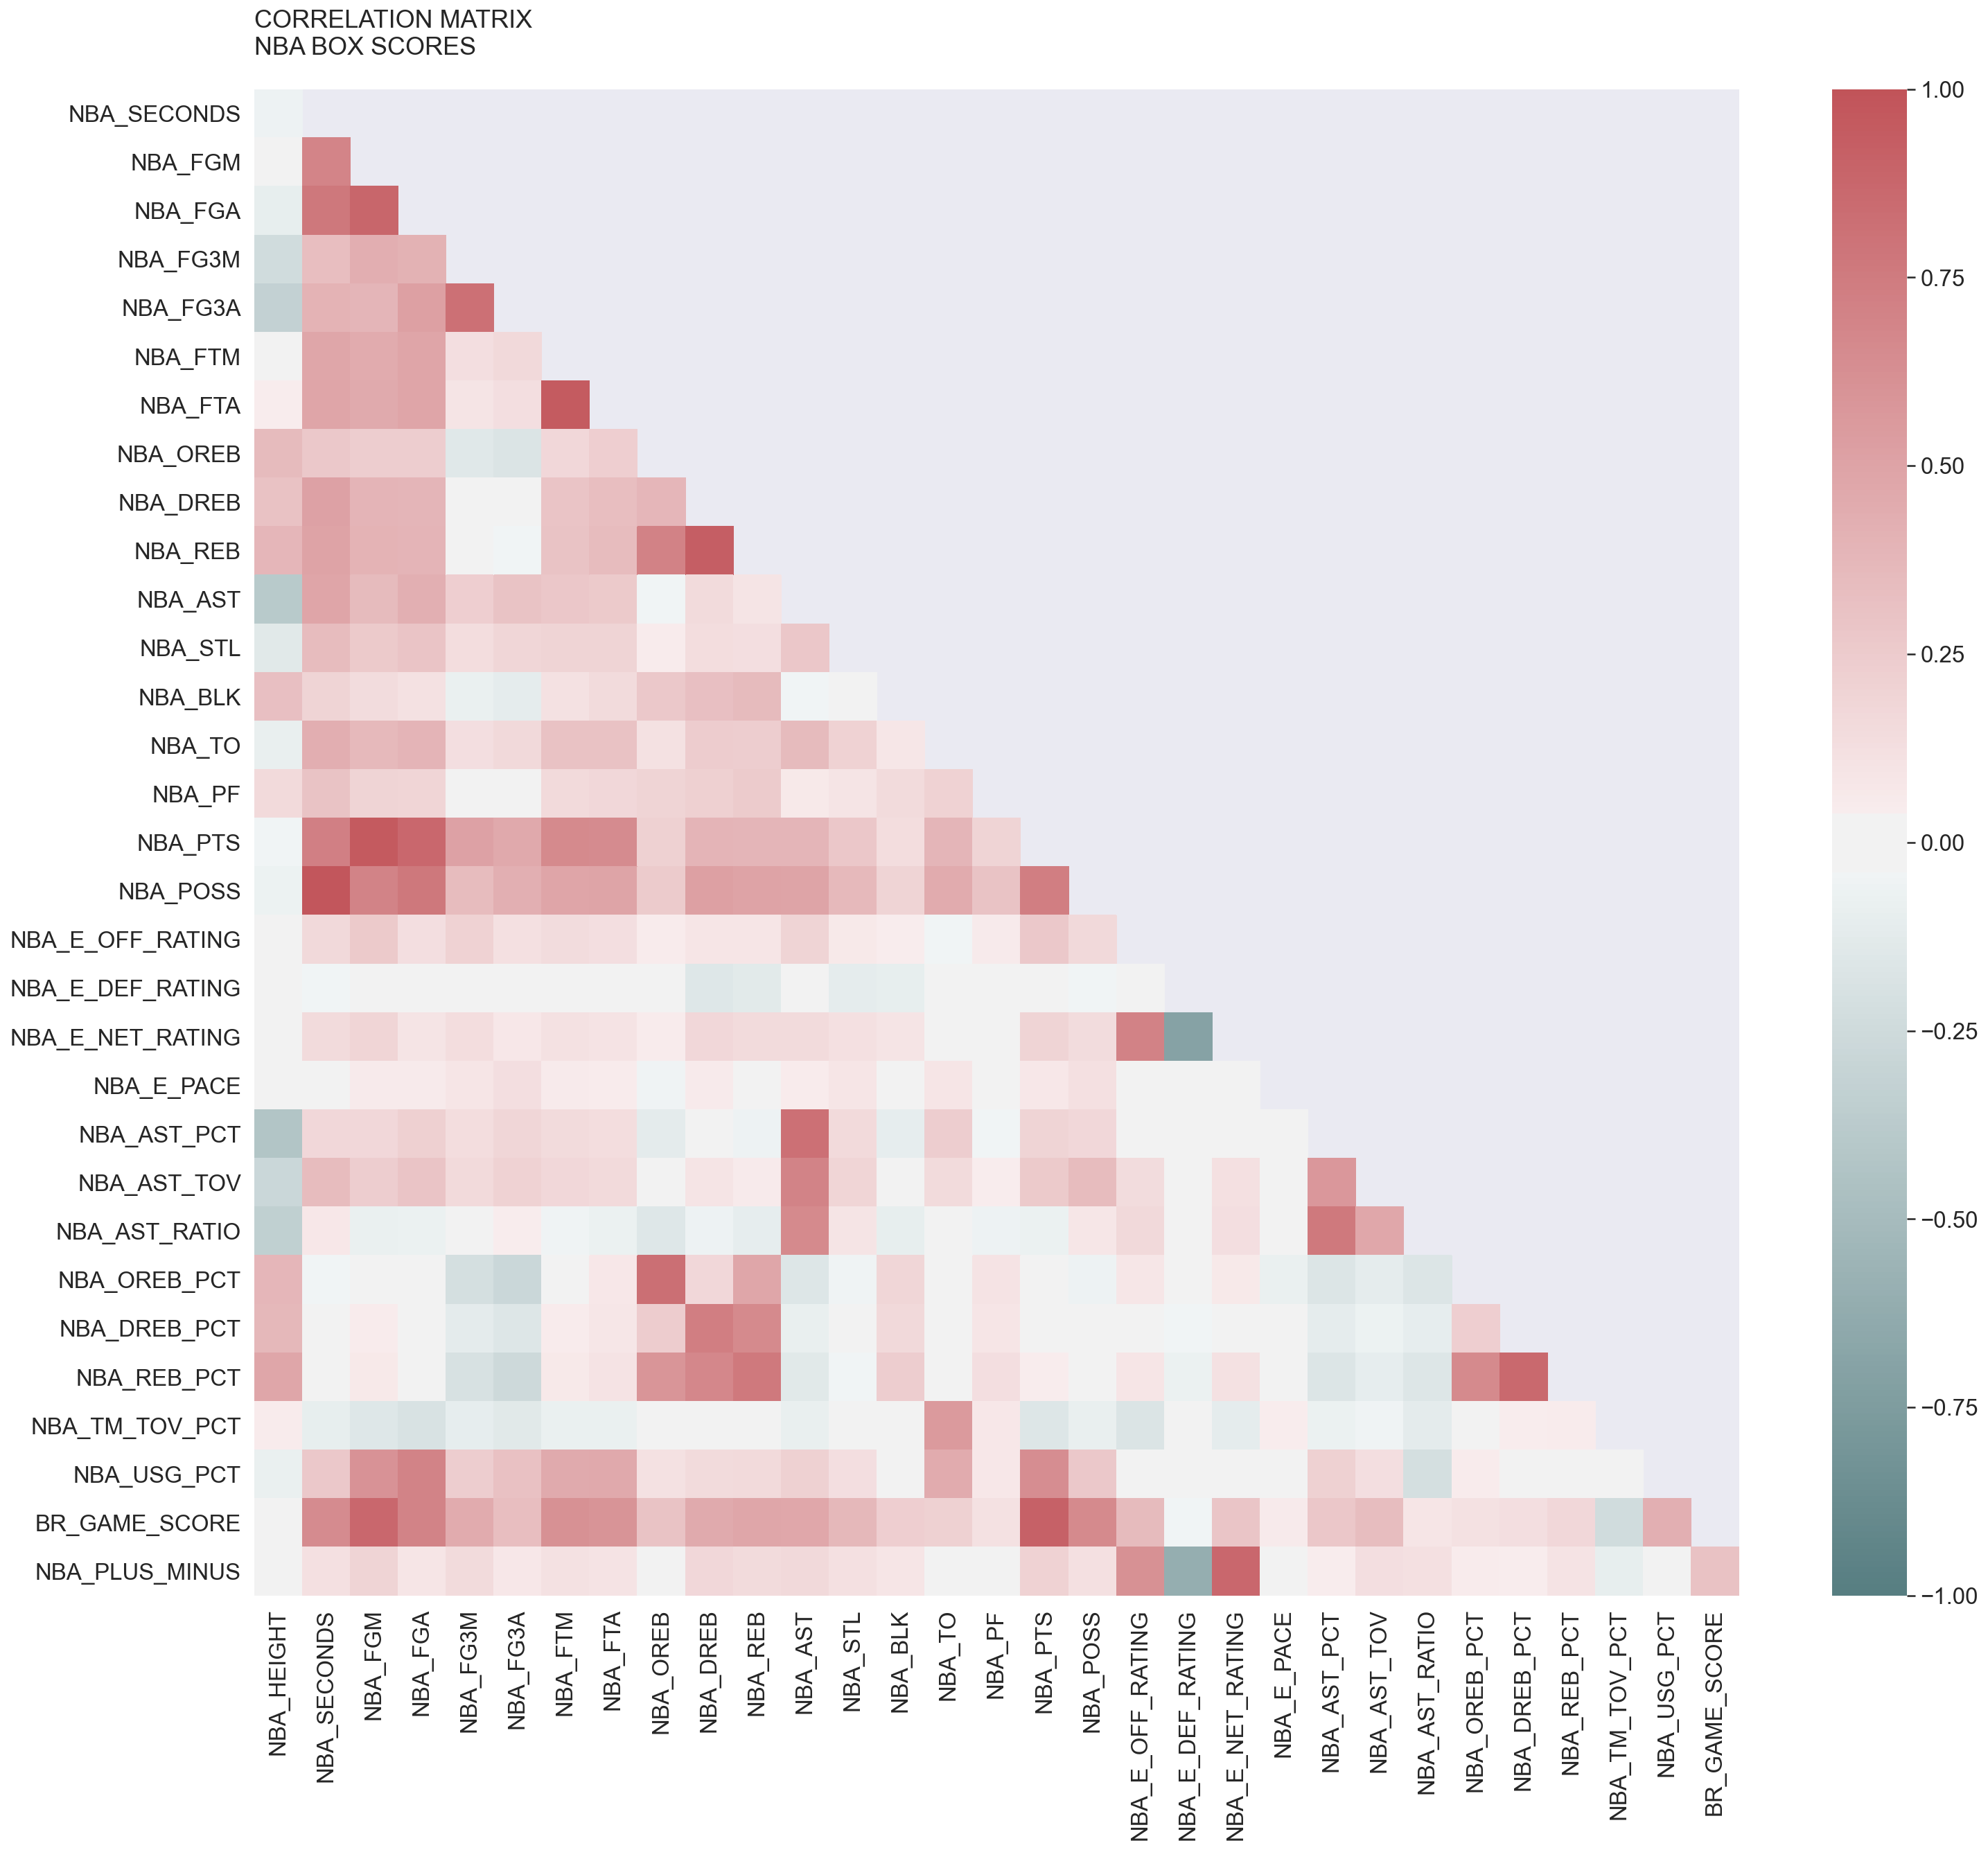

In [21]:
df_corr = df.loc[:,'age':].corr()
fig, ax = plt.subplots(figsize=(24, 20))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(200, 10, 50, n=9, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX\nNBA BOX SCORES\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_plus_minus,514704,3.32296,13.5854,-58,-6,4,12,61
age,514704,9999 days 21:26:11.369972,1557 days 14:10:45.197031,6581 days 00:00:00,8795 days 00:00:00,9813 days 00:00:00,11057 days 00:00:00,16295 days 00:00:00
nba_height,514704,2.0045,0.0909185,1.6002,1.9304,2.0066,2.0828,2.3114
nba_seconds,514704,1506.54,621.223,301,1021,1513,2003,3898
nba_fgm,514704,3.88063,3.02345,0,2,3,6,28
nba_fga,514704,8.56284,5.61813,0,4,8,12,50
nba_fg3m,514704,0.745899,1.18941,0,0,0,1,14
nba_fg3a,514704,2.0911,2.4766,0,0,1,3,24
nba_ftm,514704,1.9043,2.43419,0,0,1,3,26
nba_fta,514704,2.512,2.98787,0,0,2,4,39


In [23]:
adj_df = df.copy()
for col in columns_to_adj:
    adj_df[col] = adj_df[col] / (adj_df.nba_seconds / 60)
adj_df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_plus_minus,514704,3.32296,13.5854,-58,-6,4,12,61
age,514704,9999 days 21:26:11.369972,1557 days 14:10:45.197031,6581 days 00:00:00,8795 days 00:00:00,9813 days 00:00:00,11057 days 00:00:00,16295 days 00:00:00
nba_height,514704,2.0045,0.0909185,1.6002,1.9304,2.0066,2.0828,2.3114
nba_seconds,514704,1506.54,621.223,301,1021,1513,2003,3898
nba_fgm,514704,0.144268,0.090347,0,0.0806452,0.13913,0.200669,1.17264
nba_fga,514704,0.326539,0.145818,0,0.225322,0.320856,0.419874,1.31507
nba_fg3m,514704,0.0275159,0.0435938,0,0,0,0.0472441,0.652174
nba_fg3a,514704,0.0800564,0.0894576,0,0,0.056872,0.135211,0.980392
nba_ftm,514704,0.0689791,0.0829112,0,0,0.0470773,0.111628,1.2844
nba_fta,514704,0.0926942,0.103935,0,0,0.0701754,0.148148,1.68067


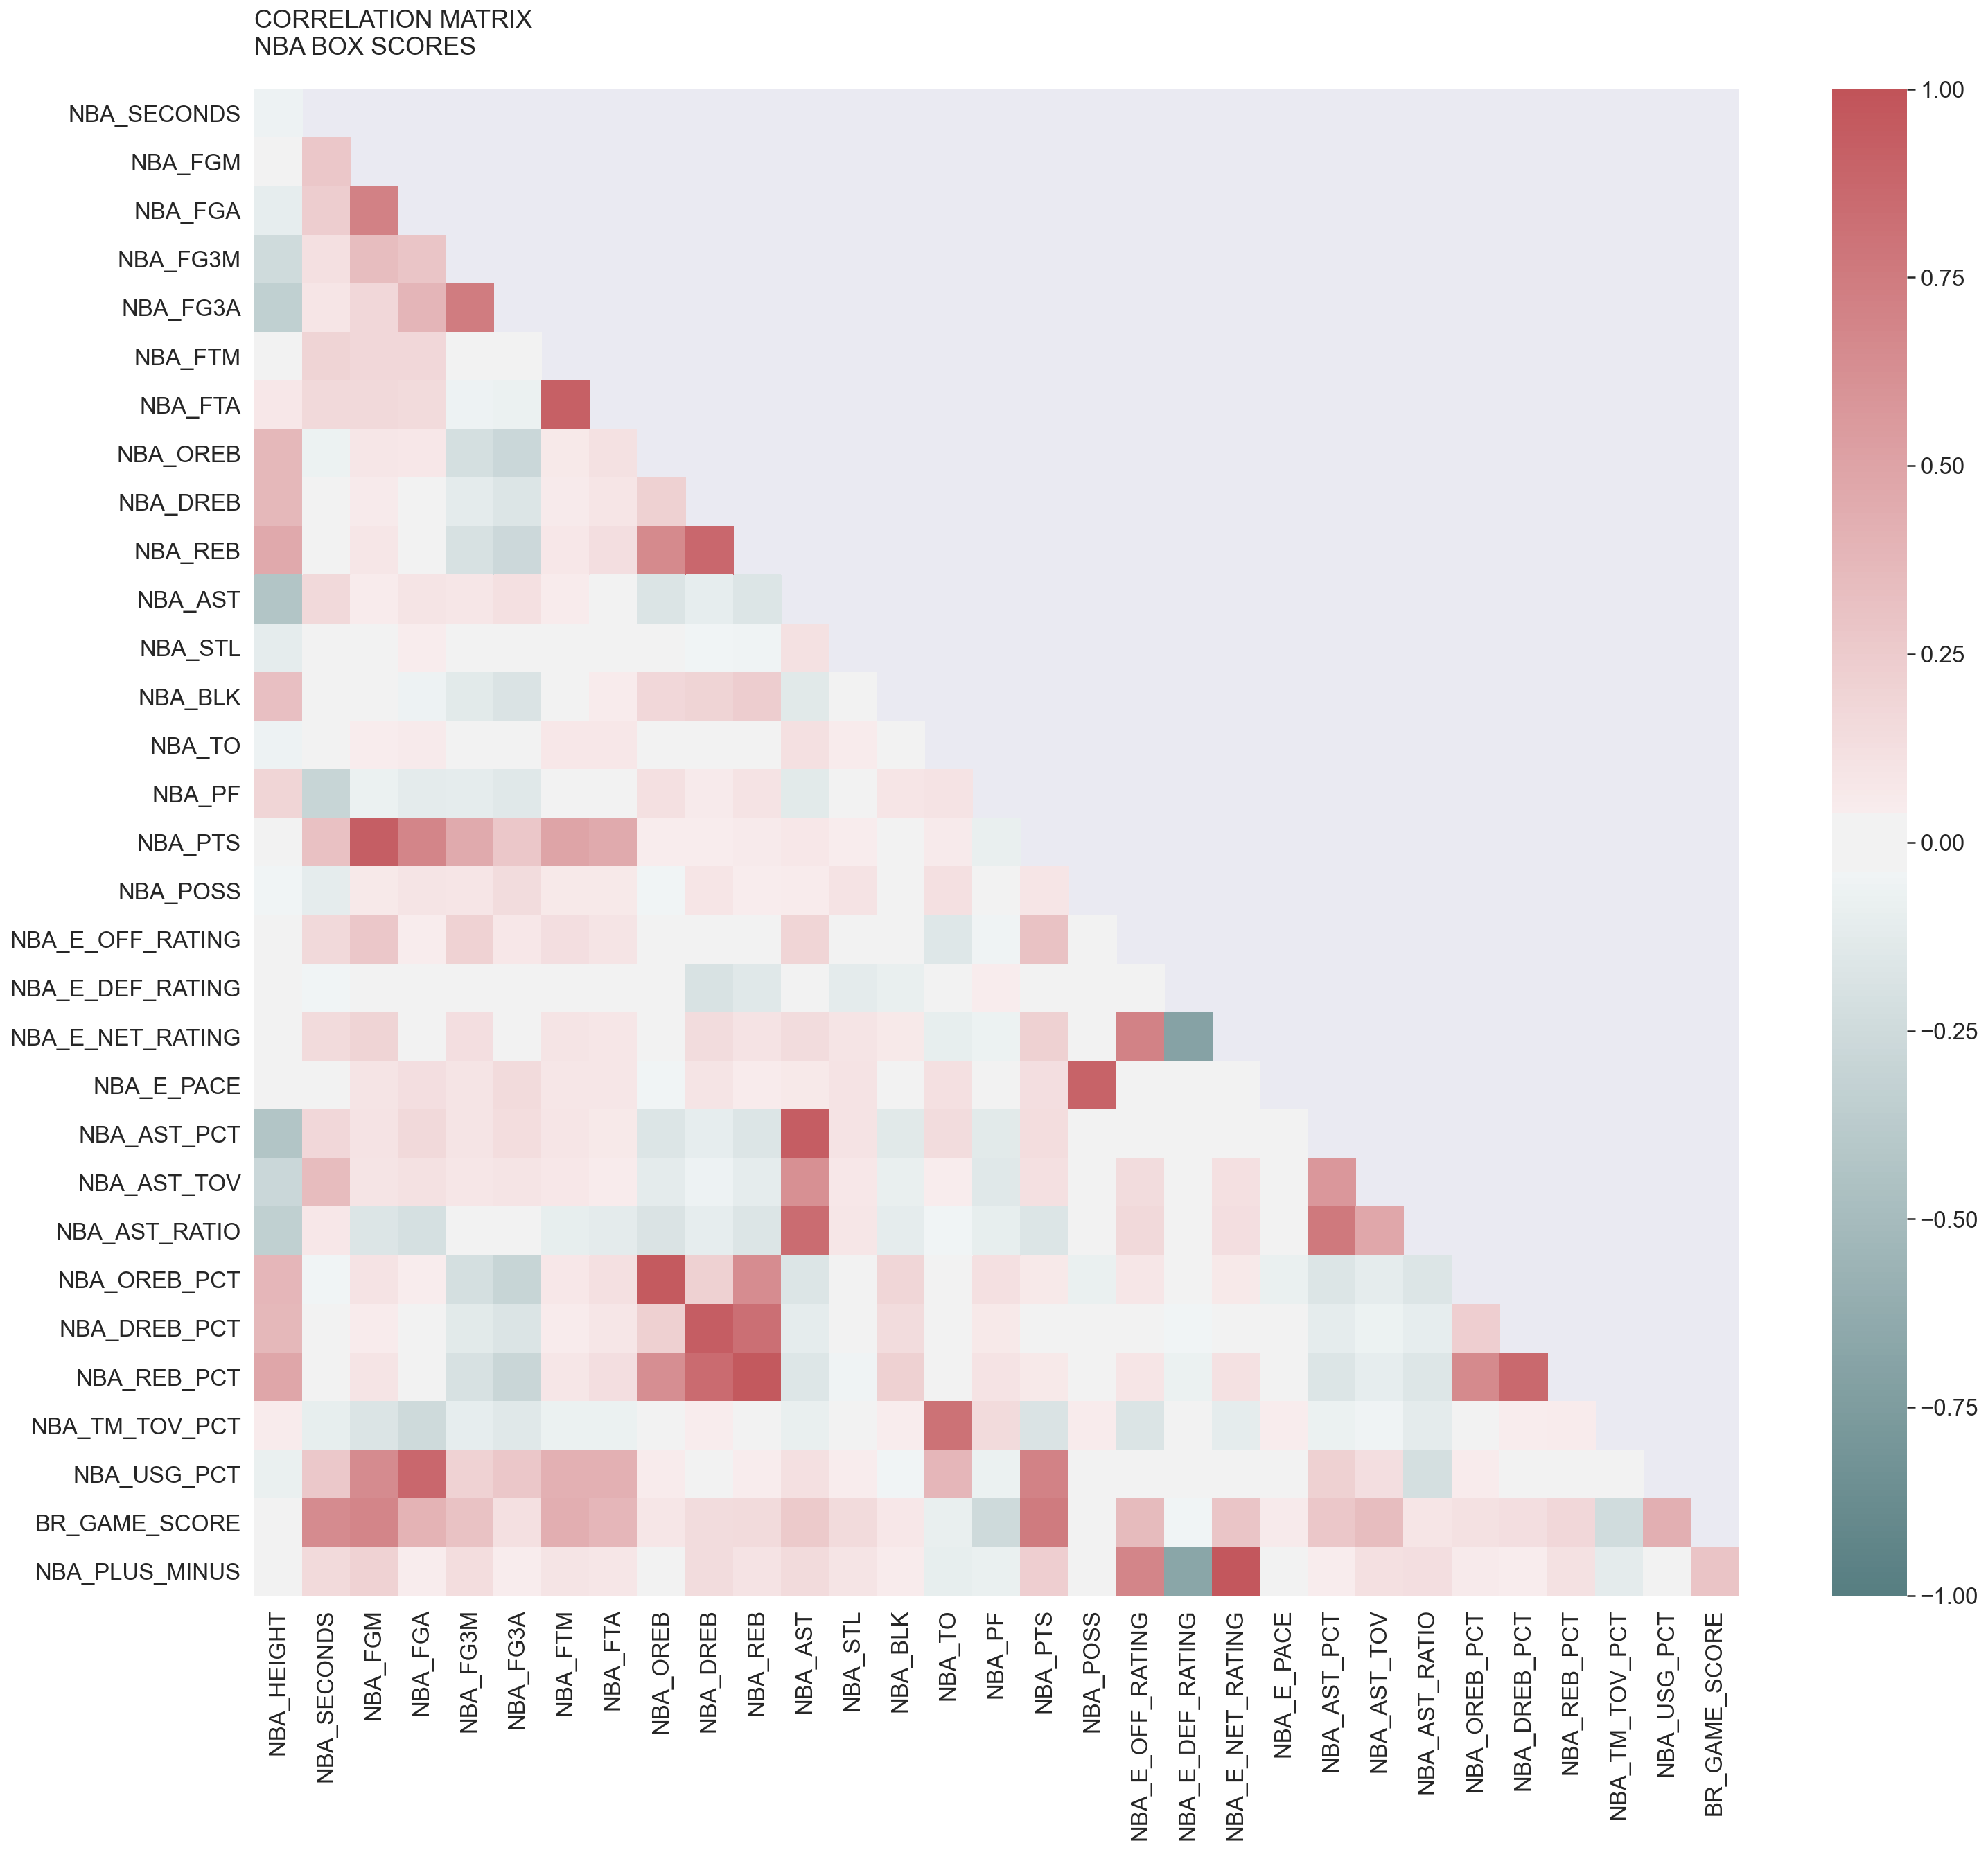

In [24]:
df_corr = adj_df.loc[:,'age':].corr()
fig, ax = plt.subplots(figsize=(24, 20))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(200, 10, 50, n=9, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX\nNBA BOX SCORES\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

In [25]:
[col for col in df.loc[:,'nba_ast_pct':] if col not in ['nba_plus_minus']]

['nba_ast_pct',
 'nba_ast_tov',
 'nba_ast_ratio',
 'nba_oreb_pct',
 'nba_dreb_pct',
 'nba_reb_pct',
 'nba_tm_tov_pct',
 'nba_usg_pct',
 'br_game_score']

In [26]:
br_glossary.keys()

dict_keys(['2P', '2P%', '2PA', '3P', '3P%', '3PA', 'Age', 'AST', 'AST%', 'Award Share', 'BLK', 'BLK%', 'BPM', 'DPOY', 'DRB', 'DRB%', 'DRtg', 'DWS', 'eFG%', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'Four Factors', 'G', 'GB', 'GmSc', 'GS', 'L', 'L Pyth', 'Lg', 'MVP', 'MP', 'MOV', 'ORtg', 'Opp', 'ORB', 'ORB%', 'OWS', 'Pace'])

In [27]:
{s:br_glossary[s] for s in ['AST%','BLK%', 'eFG%','ORB%','DRB%','GmSc','Pace']}

{'AST%': 'Assist Percentage (available since the 1964-65 season in the NBA); the  formula is 100 * AST / (((MP / (Tm MP / 5)) * Tm FG) - FG).  Assist percentage is an estimate of the percentage of teammate field goals  a player assisted while he was on the floor.',
 'BLK%': 'Block Percentage (available since the 1973-74 season in the NBA); the  formula is 100 * (BLK * (Tm MP / 5)) / (MP * (Opp FGA - Opp3PA)).  Block percentage is an estimate of the  percentage of opponent two-point field goal attempts blocked by the player  while he was on the floor.',
 'eFG%': 'Effective Field Goal Percentage; the formula is (FG +  0.5 * 3P) / FGA.  This statistic  adjusts for the fact that a 3-point field goal is worth one more point  than a 2-point field goal. For example, suppose Player A goes 4 for 10  with 2 threes, while Player B goes 5 for 10 with 0 threes. Each player  would have 10 points from field goals, and thus would have the same  effective field goal percentage (50%).',
 'ORB%': 'Offens

In [31]:
df.nba_ast_pct = df.nba_ast.apply(lambda x: x if x == 0 else np.nan) \
.fillna(df['nba_ast_pct']).apply(lambda x: x if x != 0 else np.nan)
df.nba_ast_tov = df.nba_ast.apply(lambda x: x if x == 0 else np.nan) \
.fillna(df['nba_ast_tov']).apply(lambda x: x if x != 0 else np.nan)
df.nba_ast_ratio = df.nba_ast.apply(lambda x: x if x == 0 else np.nan) \
.fillna(df['nba_ast_ratio']).apply(lambda x: x if x != 0 else np.nan)
df.nba_reb_pct = df.nba_reb.apply(lambda x: 0 if x == 0 else np.nan) \
.fillna(df['nba_reb_pct']).apply(lambda x: x if x != 0 else np.nan)
df.nba_dreb_pct = df.nba_dreb.apply(lambda x: 0 if x == 0 else np.nan) \
.fillna(df['nba_dreb_pct']).apply(lambda x: x if x != 0 else np.nan)
df.nba_oreb_pct = df.nba_oreb.apply(lambda x: 0 if x == 0 else np.nan) \
.fillna(df['nba_oreb_pct']).apply(lambda x: x if x != 0 else np.nan)

In [32]:
df.nba_oreb.apply(lambda x: 0 if x == 0 else np.nan) \
.fillna(df['nba_oreb_pct']).apply(lambda x: x if x != 0 else np.nan)

0           NaN
1           NaN
2           NaN
3           NaN
4         0.038
          ...  
554636    0.167
554642    0.250
554643    0.167
554644    0.300
554645      NaN
Name: nba_oreb, Length: 514704, dtype: float64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514704 entries, 0 to 554645
Data columns (total 46 columns):
nba_game_date            514704 non-null object
nba_season_id            514704 non-null category
br_location              514704 non-null object
nba_gm_type              514704 non-null object
br_outcome               514704 non-null object
home_plus_minus          514704 non-null int64
nba_game_id              514704 non-null category
nba_team_id              514704 non-null category
nba_team_abbreviation    514704 non-null object
nba_team_city            514704 non-null object
nba_player_id            514704 non-null category
nba_player_name          514704 non-null object
nba_start_position       269063 non-null object
age                      514704 non-null timedelta64[ns]
nba_height               514704 non-null float64
nba_seconds              514704 non-null int64
nba_fgm                  514704 non-null float64
nba_fga                  514704 non-null float64
nba_fg3

In [38]:
for col in df:
    try:
        print(f'{list(df.columns).index(col)} {col} :    \t {len(df[df[col]==0])}')
    except:
        print(f'{col}\t: ERROR')

0 nba_game_date :    	 0
1 nba_season_id :    	 0
2 br_location :    	 0
3 nba_gm_type :    	 0
4 br_outcome :    	 0
5 home_plus_minus :    	 0
6 nba_game_id :    	 0
7 nba_team_id :    	 0
8 nba_team_abbreviation :    	 0
9 nba_team_city :    	 0
10 nba_player_id :    	 0
11 nba_player_name :    	 0
12 nba_start_position :    	 0
13 age :    	 0
14 nba_height :    	 0
15 nba_seconds :    	 0
16 nba_fgm :    	 52043
17 nba_fga :    	 9431
18 nba_fg3m :    	 312575
19 nba_fg3a :    	 200312
20 nba_ftm :    	 210598
21 nba_fta :    	 191573
22 nba_oreb :    	 224617
23 nba_dreb :    	 59760
24 nba_reb :    	 38736
25 nba_ast :    	 136203
26 nba_stl :    	 257636
27 nba_blk :    	 346301
28 nba_to :    	 156207
29 nba_pf :    	 69544
30 nba_pts :    	 37534
31 nba_poss :    	 0
32 nba_e_off_rating :    	 29
33 nba_e_def_rating :    	 10
34 nba_e_net_rating :    	 1077
35 nba_e_pace :    	 0
36 nba_ast_pct :    	 0
37 nba_ast_tov :    	 0
38 nba_ast_ratio :    	 0
39 nba_oreb_pct :    	 

In [39]:
df.loc[:,'nba_team_abbreviation':]

,nba_team_abbreviation,nba_team_city,nba_player_id,nba_player_name,nba_start_position,age,nba_height,nba_seconds,nba_fgm,nba_fga,...,nba_ast_pct,nba_ast_tov,nba_ast_ratio,nba_oreb_pct,nba_dreb_pct,nba_reb_pct,nba_tm_tov_pct,nba_usg_pct,br_game_score,nba_plus_minus
0,POR,Portland,21,Greg Anthony,NaN,11675 days,1.8542,1347,3.0,4.0,...,0.381,8.0,61.5,NaN,0.069,0.051,7.7,0.114,10.8,18.0
1,IND,Indiana,22,Rik Smits,C,12124 days,2.2352,1015,2.0,7.0,...,0.167,NaN,18.2,NaN,NaN,NaN,0.0,0.225,0.9,6.0
2,LAL,Los Angeles,216,Brian Shaw,NaN,12278 days,1.9812,645,1.0,4.0,...,0.143,1.0,14.3,NaN,NaN,NaN,14.3,0.240,1.2,-1.0
3,TOR,Toronto,209,Dell Curry,NaN,12913 days,1.9558,1211,3.0,8.0,...,0.222,NaN,20.0,NaN,0.235,0.100,0.0,0.174,5.2,-4.0
4,TOR,Toronto,213,Antonio Davis,C,11324 days,2.0574,1656,1.0,7.0,...,0.125,1.0,14.3,0.038,0.095,0.064,14.3,0.197,2.6,-20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554636,DET,Detroit,203502,Tony Mitchell,NaN,7966 days,2.0320,336,0.0,0.0,...,NaN,NaN,NaN,0.167,0.250,0.200,0.0,0.143,5.0,-9.0
554642,DET,Detroit,203502,Tony Mitchell,NaN,8026 days,2.0320,346,1.0,1.0,...,0.250,1.0,33.3,0.250,0.200,0.222,33.3,0.182,1.6,3.0
554643,DET,Detroit,203502,Tony Mitchell,NaN,8037 days,2.0320,503,0.0,2.0,...,NaN,NaN,NaN,0.167,0.444,0.286,0.0,0.130,3.5,7.0
554644,DET,Detroit,203502,Tony Mitchell,NaN,8041 days,2.0320,401,1.0,2.0,...,NaN,NaN,NaN,0.300,NaN,0.250,33.3,0.150,2.1,-4.0


In [40]:
new_columns = []
for col in df:
    new_col = input(f'New column name for {col} : ')
    new_columns.append(new_col)

New column name for nba_game_date : date
New column name for nba_season_id : season_id
New column name for br_location : location
New column name for nba_gm_type : type
New column name for br_outcome : outcome
New column name for home_plus_minus : difference
New column name for nba_game_id : game_id
New column name for nba_team_id : team_id
New column name for nba_team_abbreviation : team_abb
New column name for nba_team_city : team_city
New column name for nba_player_id : player_id
New column name for nba_player_name : name
New column name for nba_start_position : start_position
New column name for age : age_days
New column name for nba_height : height
New column name for nba_seconds : seconds
New column name for nba_fgm : fgm
New column name for nba_fga : fga
New column name for nba_fg3m : fg3m
New column name for nba_fg3a : fg3a
New column name for nba_ftm : ftm
New column name for nba_fta : fta
New column name for nba_oreb : oreb
New column name for nba_dreb : dreb
New column name 

In [41]:
df.columns = new_columns

In [42]:
df.columns

Index(['date', 'season_id', 'location', 'type', 'outcome', 'difference',
       'game_id', 'team_id', 'team_abb', 'team_city', 'player_id', 'name',
       'start_position', 'age_days', 'height', 'seconds', 'fgm', 'fga', 'fg3m',
       'fg3a', 'ftm', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'to',
       'pf', 'pts', 'poss', 'off_rate', 'def_rate', 'net_rate', 'pace',
       'ast_pct', 'ast_tov', 'ast_ratio', 'oreb_pct', 'dreb_pct', 'reb_pct',
       'tm_tov_pct', 'usg_pct', 'game_score', 'plus_minus'],
      dtype='object')

In [43]:
df.head()

,date,season_id,location,type,outcome,difference,game_id,team_id,team_abb,team_city,...,ast_pct,ast_tov,ast_ratio,oreb_pct,dreb_pct,reb_pct,tm_tov_pct,usg_pct,game_score,plus_minus
0,1999-11-02,21999,AWAY,Regular,W,-20,29900013,1610612757,POR,Portland,...,0.381,8.0,61.5,NaN,0.069,0.051,7.7,0.114,10.8,18.0
1,1999-11-02,21999,AWAY,Regular,W,-7,29900002,1610612754,IND,Indiana,...,0.167,NaN,18.2,NaN,NaN,NaN,0.0,0.225,0.9,6.0
2,1999-11-02,21999,AWAY,Regular,W,-7,29900011,1610612747,LAL,Los Angeles,...,0.143,1.0,14.3,NaN,NaN,NaN,14.3,0.240,1.2,-1.0
3,1999-11-02,21999,HOME,Regular,L,-13,29900006,1610612761,TOR,Toronto,...,0.222,NaN,20.0,NaN,0.235,0.100,0.0,0.174,5.2,-4.0
4,1999-11-02,21999,HOME,Regular,L,-13,29900006,1610612761,TOR,Toronto,...,0.125,1.0,14.3,0.038,0.095,0.064,14.3,0.197,2.6,-20.0


In [44]:
df.to_csv('mainset2.csv', index=False)

### Look for groups for player position
- classification for positions
- clustering

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics

In [ ]:
import pickle
with open('position_dict.pickle', 'rb') as f:
    position_dict = pickle.load(f)

In [ ]:
xf.index.map(position_dict).fillna('none').value_counts()

In [ ]:
X = xf.copy()
X['target'] = X.index.map(position_dict)
X.drop(X[X['target'].isna()].index, inplace=True)
y = X.pop('target')
y.value_counts()

In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures

In [ ]:
test = poly.fit_transform(X_train)

In [ ]:
poly.get_feature_names([c for c in X_train if c!=0])

In [ ]:
pd.DataFrame(poly.transform(X_train),
             columns=poly.get_feature_names([c for c in X_train if c!=0]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                    stratify=y, test_size=0.2, random_state=1)

poly = PolynomialFeatures()
poly.fit(X_train)
X_train = pd.DataFrame(poly.transform(X_train),
                       columns=poly.get_feature_names([c for c in X_train if c!=0]))
X_test = pd.DataFrame(poly.transform(X_test),
                       columns=poly.get_feature_names([c for c in X_train if c!=0]))

power = PowerTransformer()
X_train = pd.DataFrame(power.fit_transform(X_train),
                       columns=X_train.columns)
X_test = pd.DataFrame(power.transform(X_test),
                      columns=X_train.columns)

In [ ]:
def log_fit_display(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                    c_min=-4,c_max=2, c_space=10,
                    l1_min=.0001,l1_max=.9999, l1_space=10):

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    lr_model = LogisticRegression(max_iter=1000000)

    solvers = ['saga']
    penalty = ['elasticnet']
    c_values = np.logspace(c_min,c_max,c_space)
    multi_class = ['ovr', 'multinomial']
    fit_intercept = [True,False]
    l1_ratios = np.linspace(l1_min,l1_max,l1_space)

    gs_params = {'penalty': penalty,
                 'solver': solvers,
                 'l1_ratio': l1_ratios,
                 'C': c_values,
                 'multi_class': multi_class,
                 'fit_intercept': fit_intercept}

    lr_grid = GridSearchCV(lr_model, gs_params, n_jobs=2, verbose=3, cv=kf)

    lr_grid.fit(X_train, y_train)
    
    print('=' * 40)

    print('Train score : ', lr_grid.score(X_train, y_train))
    print('Test score  : ', lr_grid.score(X_test, y_test))
    print('Mean score. : ', lr_grid.best_score_)
    print('Best params :\n', lr_grid.best_params_,'\n----------')

    print('Train : \n', metrics.classification_report(
        y_train, lr_grid.predict(X_train)),'\n')
    print('Test. : \n', metrics.classification_report(
        y_test, lr_grid.predict(X_test)),'\n')

    plot_confusion_matrix(lr_grid.best_estimator_,
                          X_test, y_test, cmap=plt.cm.binary)
    plt.show()
    plot_confusion_matrix(lr_grid.best_estimator_,
                          X_train, y_train, cmap=plt.cm.binary,)
    plt.show()
    return lr_grid

In [ ]:
lr_grid = log_fit_display()

In [ ]:
lr_grid2 = log_fit_display(c_min=-1,c_max=1,l1_min=.3,l1_max=.55)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                    stratify=y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print('Train score : ', lr_grid.score(X_train, y_train))
print('Test score  : ', lr_grid.score(X_test, y_test))
print('Mean score. : ', lr_grid.best_score_)
print(lr_grid.best_params_)

print('Train : \n', metrics.classification_report(
    y_train, lr_grid.predict(X_train)))
print('Test. : \n', metrics.classification_report(
    y_test, lr_grid.predict(X_test)))

plot_confusion_matrix(lr_grid.best_estimator_,
                      X_test, y_test, cmap=plt.cm.binary)
plt.show()
plot_confusion_matrix(lr_grid.best_estimator_,
                      X_train, y_train, cmap=plt.cm.binary,)
plt.show()

In [ ]:
pd.DataFrame(lr_grid.best_estimator_.coef_,
             columns=X_train.get_feature_names(X.columns),
            index=['C','F','F/C','G','G/F','G/F/C']
            ).sort_values(by='nba_height')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, max_features='sqrt')

rfc_params = {'criterion' : ['gini','entropy'],
              'max_depth' : [3,5,None]}

rfc_grid = GridSearchCV(rfc, rfc_params, n_jobs=2, verbose=3)

rfc_grid.fit(X_train, y_train)

print('Train R2 score : ', rfc_grid.score(X_train, y_train))
print('Test R2 score  : ', rfc_grid.score(X_test, y_test))
print('Mean CV score. : ', rfc_grid.best_score_)
print(rfc_grid.best_params_)
print('Train : \n', metrics.classification_report(
    y_train, rfc_grid.predict(X_train)))
print('Test. : \n', metrics.classification_report(
    y_test, rfc_grid.predict(X_test)))

plot_confusion_matrix(rfc_grid.best_estimator_,
                      X_test, y_test, cmap=plt.cm.binary)
plt.show()
plot_confusion_matrix(rfc_grid.best_estimator_,
                      X_train, y_train, cmap=plt.cm.binary,)
plt.show()

In [ ]:
# No real surprises here that height is the most important 

pd.DataFrame(zip(rfc_grid.best_estimator_.feature_importances_,
                 X.columns),
             columns=['feat_importances','X_variable']
            ).sort_values('feat_importances',ascending=False)

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC()

gs_clf_params = {'gamma' : np.logspace(-4, 1, 10),
                  'C' : np.logspace(-3, 1, 10),
                  'kernel' : ['linear', 'sigmoid']}

gs_clf = GridSearchCV(clf, gs_clf_params, n_jobs=2, verbose=3)

gs_clf.fit(X_train, y_train)

print(gs_clf.best_params_)

pred_train = gs_clf.predict(X_train)
pred_test = gs_clf.predict(X_test)

print(metrics.classification_report(y_train, gs_clf.predict(X_train)))
print(metrics.classification_report(y_test, gs_clf.predict(X_test)))
plot_confusion_matrix(gs_clf.best_estimator_,
                      X_test, y_test, cmap=plt.cm.binary)
plt.show()
plot_confusion_matrix(gs_clf.best_estimator_,
                      X_train, y_train, cmap=plt.cm.binary,)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500, max_features='sqrt',
                                 n_iter_no_change=30)

gbc_params = {'loss' : ['deviance','exponential'],
              'max_depth' : [3,5],
              'learning_rate' : [.1,.3,.5]}

gbc_grid = GridSearchCV(gbc, gbc_params, n_jobs=2, verbose=3)

gbc_grid.fit(X_train, y_train)

print('Train R2 score : ', gbc_grid.score(X_train, y_train))
print('Test R2 score  : ', gbc_grid.score(X_test, y_test))
print('Mean CV score. : ', gbc_grid.best_score_)
print(gbc_grid.best_params_)
print('Train : \n', metrics.classification_report(
    y_train, gbc_grid.predict(X_train)))
print('Test. : \n', metrics.classification_report(
    y_test, gbc_grid.predict(X_test)))

plot_confusion_matrix(gbc_grid.best_estimator_,
                      X_test, y_test, cmap=plt.cm.binary)
plt.show()
plot_confusion_matrix(gbc_grid.best_estimator_,
                      X_train, y_train, cmap=plt.cm.binary,)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [ ]:
X

In [ ]:
Xstd = scaler.fit_transform(X)
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(Xstd)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xstd, cluster_labels)
    print("For n_clusters =", n_clusters,
          "the average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xstd, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Xstd[:, 0], Xstd[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()